In [2]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

In [3]:
# 1. load dataset and preprocess text data by lowercasing, removing URLs, @s, and non-alphanumeric characters
# Our dataset was downloaded from: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment
df = pd.read_csv('Tweets.csv')   
df['clean'] = (
    df['text']
      .str.lower()
      .str.replace(r"http\S+|www\.\S+", "", regex=True)
      .str.replace(r"@\w+", "",             regex=True)
      .str.replace(r"[^a-z0-9\s]", "",      regex=True)
      .str.strip()
)
label_map = {'negative':0, 'neutral':1, 'positive':2}
df['label'] = df['airline_sentiment'].map(label_map)

# 2. 70/15/15 Split for train, validation, and test sets
train, temp = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=42)
val, test  = train_test_split(temp, test_size=0.50, stratify=temp['label'], random_state=42)

X_train, y_train = train['clean'], train['label']
X_val,   y_val   = val  ['clean'], val  ['label']
X_test,  y_test  = test ['clean'], test ['label']

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        max_df=0.7,
        min_df=3,
        max_features=10000,
        sublinear_tf=True
    )),
    ('clf', LogisticRegression(
        C=1,
        class_weight='balanced',
        max_iter=5000,
        random_state=42
    ))
])

pipeline.fit(X_train, y_train)

# 4. Validation metrics
y_val_pred = pipeline.predict(X_val)
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.3f}")
print(classification_report(y_val, y_val_pred, target_names=label_map.keys()))

# 5. Test metrics
y_test_pred = pipeline.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print(classification_report(y_test, y_test_pred, target_names=label_map.keys()))


Validation Accuracy: 0.786
              precision    recall  f1-score   support

    negative       0.89      0.83      0.86      1376
     neutral       0.58      0.71      0.64       465
    positive       0.73      0.72      0.73       355

    accuracy                           0.79      2196
   macro avg       0.74      0.75      0.74      2196
weighted avg       0.80      0.79      0.79      2196

Test Accuracy: 0.791
              precision    recall  f1-score   support

    negative       0.89      0.84      0.86      1377
     neutral       0.60      0.69      0.64       465
    positive       0.72      0.74      0.73       354

    accuracy                           0.79      2196
   macro avg       0.73      0.76      0.74      2196
weighted avg       0.80      0.79      0.79      2196



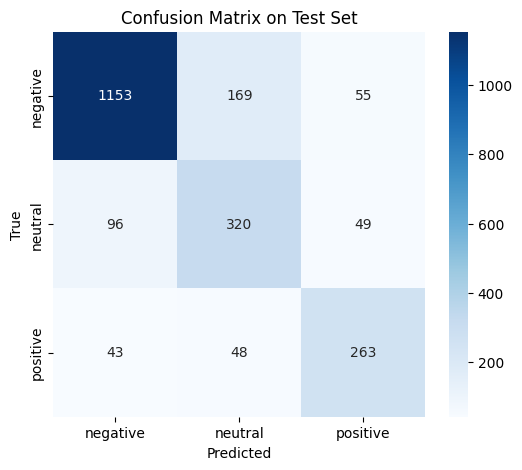

Example correctly classified tweet:

Tweet:  @AmericanAir Way to suck at customer service, Dallas is trapped in an ice storm but you didn't Cancelled Flight 7am flight &amp; been on hold all day.
True:   negative
Predicted: negative


In [16]:
train = train.reset_index(drop=True)
val   = val.reset_index(drop=True)
test  = test.reset_index(drop=True)

y_test = test['label'].values

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support


y_test_pred = pipeline.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=[0,1,2])
labels = ['negative','neutral','positive']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Set')
plt.show()



# map back ints to labels
id2label = {v:k for k,v in label_map.items()}

# find a correctly classified example and display 
correct_idxs = [i for i,(t,p) in enumerate(zip(y_test, y_test_pred)) if t==p]
if correct_idxs:
    idx = np.random.choice(correct_idxs)
    tweet = test.iloc[idx]['text']
    true_lbl = id2label[y_test[idx]]
    pred_lbl = id2label[y_test_pred[idx]]
    print("Example correctly classified tweet:\n")
    print(f"Tweet:  {tweet}")
    print(f"True:   {true_lbl}")
    print(f"Predicted: {pred_lbl}")
else:
    print("No correctly classified examples found.")
